# Simple Neural Network: Coffee Roast Classifier


In [7]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('./deeplearning.mplstyle')

import tensorflow as tf
# from tensorflow.keras.layers import Dense # type: ignore
# from keras.layers import Dense

from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

import time
import datetime


In [8]:
NN_SEED = 111
NN_LEARNING_RATE = 0.01
NN_EARLY_STOPPING_MIN_DELTA = 0.001
NN_EARLY_STOPPING_PATIENCE = 5
NN_MODEL_SAVE_PATH = "./saved_models/"
NN_MODEL_SAVE_FIG = "./saved_models/figures/"

# 1. Load the dataset and visualize it

In [9]:
X,Y = load_coffee_data();

print(f"Type X, Y: {type(X), type(Y)}")
print(X.shape, Y.shape)

Type X, Y: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
(200, 2) (200, 1)


In [10]:
print(X[:5])
print(Y[:5])

[[185.32  12.69]
 [259.92  11.87]
 [231.01  14.41]
 [175.37  11.72]
 [187.12  14.13]]
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]]


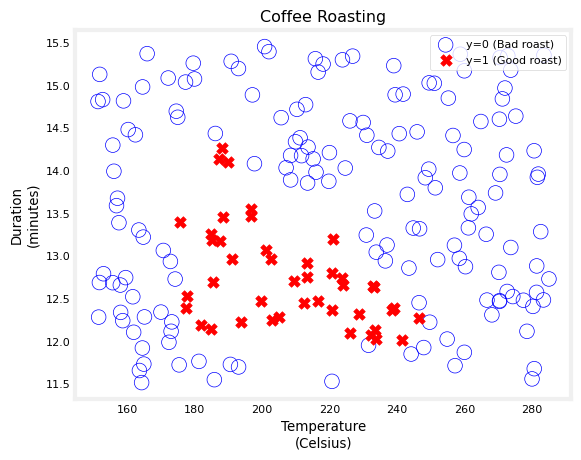

In [11]:
# 2D scatter plot of the data 
# marker 'o' denote points which y = 0
# marker 'x' denote points which y = 1

""" Syntax:
- marker='o' | 'x' | 'X'            : marked marker
- facecolors='none' | 'green' | ... : inside color of circle marker
- edgecolors='none' | 'blue' | ...  : edge color of circle marker
- s=111 | 22 | ...                  : size of marker
- c='red' | ...                     : color of marker
"""
plt.scatter(x=X[Y.flatten()==0, 0], y=X[Y.flatten()==0, 1], marker='o', label='y=0 (Bad roast)', facecolors='none', edgecolors='blue', s=111)
plt.scatter(x=X[Y.flatten()==1, 0], y=X[Y.flatten()==1, 1], marker='X', label='y=1 (Good roast)', c='red', s=69)

plt.legend(loc='upper right')
plt.xlabel("Temperature\n(Celsius)")
plt.ylabel("Duration\n(minutes)")
plt.title("Coffee Roasting")

plt.show();

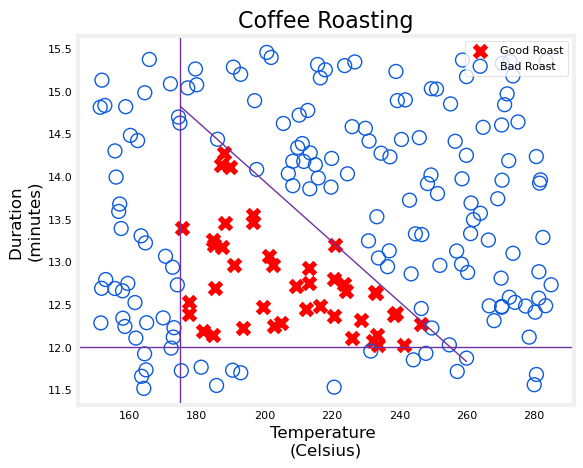

In [12]:
plt_roast(X, Y)

# 2. Normalize the data

Normalize data &rarr; quickly fitting the weights of the neural network.

In [13]:
print(f"(-) Temperature(Celsius) pre normalization: Max, Min: {np.max(X[:, 0]):.2f}, {np.min(X[:, 0]):.2f}")
print(f"(-) Duration(minutes) pre normalization: Max, Min: {np.max(X[:, 1]):.2f}, {np.min(X[:, 1]):.2f}")


# Create a "Normalization layer"
norm_layer = tf.keras.layers.Normalization(axis=-1) # by column
# Learn mean & variances
norm_layer.adapt(X) #  (like module.fit())
# Normalize
X_norm = norm_layer(X)


print(f"(+) Temperature(Celsius) post normalization: Max, Min: {np.max(X_norm[:, 0]):.2f}, {np.min(X_norm[:, 0]):.2f}")
print(f"(+) Duration(minutes) post normalization: Max, Min: {np.max(X_norm[:, 1]):.2f},  {np.min(X_norm[:, 1]):.2f}")
    

(-) Temperature(Celsius) pre normalization: Max, Min: 284.99, 151.32
(-) Duration(minutes) pre normalization: Max, Min: 15.45, 11.51
(+) Temperature(Celsius) post normalization: Max, Min: 1.66, -1.69
(+) Duration(minutes) post normalization: Max, Min: 1.79,  -1.70


2025-12-17 12:26:12.295969: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Tile/replicate data &rarr; increase dataset size for better training.
But it consumes more memory and we just want to demonstrate the neural network.

Instead of using 200 samples and train the model with 1000 epochs,

```model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=1)```

We tile the data to have 200,000 samples and train with 10 epochs.

In [14]:
X_tile = np.tile(X_norm, (1000, 1)) # tile/replicate 1000 times by axis=0 (rows) and 1 time by column
Y_tile = np.tile(Y, (1000, 1))

print(X_tile.shape, Y_tile.shape)

(200000, 2) (200000, 1)


# 3. TensorFlow Neural Network Model

## 3.1 Design Model

<center>
<img src="./images/C2_W1_RoastingNetwork.PNG" alt="Neural Network Architecture"/>
<br>
Figure: Neural Network Architecture
</center>

There are 2 layers with sigmoid activation function.

In [15]:
# Init weights and biases randomly with this seed (Glorot Uniform Initializer)
tf.random.set_seed(NN_SEED) # For reproducibility (archive same results each run)
# Design model:
model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(units=3, activation='sigmoid', name='layer1'),
        tf.keras.layers.Dense(units=1, activation='sigmoid', name='layer2')
    ]
)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

Params:

In layer 1: 2*3 + 3 = 9<br>
Because layer 1 has 3 units(neurons), each input array shape: (2,) and plus 3 bias terms. e.g:
  - Unit 1: $w^{[1]}_{1} x_1 + w^{[1]}_{2} x_2 + b^{[1]}$
  - Unit 2: $w^{[2]}_{1} x_1 + w^{[2]}_{2} x_2 + b^{[2]}$
  - Unit 3: $w^{[3]}_{1} x_1 + w^{[3]}_{2} x_2 + b^{[3]}$

In layer 2: 3*1 + 1 = 4<br>
Because layer 2 has 1 unit(neuron), each input array shape: (3,) that is the output of layer 1 and plus 1 bias term. e.g:
  - Unit 1: $w^{[1]}_{1} a^{[1]}_1 + w^{[1]}_{2} a^{[1]}_2 + w^{[1]}_{3} a^{[1]}_3 + b^{[1]}$

In [17]:
L1_num_params = 2*3 + 3 
L2_num_params = 3*1 + 1 

print(f"L1 params = {L1_num_params},\nL2 params = {L2_num_params}")

L1 params = 9,
L2 params = 4


Examine the weights and biases TF has instantiated.<br>
The weights W should be:<br>

<!-- `(number of features in input, number of units in layer)` -->
$$
(\text{number of features in input}, \text{number of units in layer})
$$

- First layer, W shape: (2, 3)<br>
Because there are 2 features input and 3 units
- Second layer, W shape: (3, 1)<br>
Because there are 3 inputs from previous layer and 1 unit

Get **randomly initialized** weights and biases

In [18]:
W1, b1 = model.get_layer('layer1').get_weights()
W2, b2 = model.get_layer('layer2').get_weights()

print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}: ", b1, "\n")
print(f"W2{W2.shape}:\n", W2, f"\nb1{b2.shape}: ", b2, "\n")

W1(2, 3):
 [[-0.22 -0.46 -0.21]
 [-0.31  1.08  0.12]] 
b1(3,):  [0. 0. 0.] 

W2(3, 1):
 [[-0.68]
 [-1.14]
 [ 0.87]] 
b1(1,):  [0.] 



## Testing set weight and bias values


In [19]:
# W1 = np.array([
#     [-8.94,  0.29, 12.89],
#     [-0.17, -7.34, 10.79]] )
# b1 = np.array([-9.87, -9.28,  1.01])
# W2 = np.array([
#     [-31.38],
#     [-27.86],
#     [-32.79]])
# b2 = np.array([15.54])

# # Replace the weights from your trained model with
# # the values above.
# model.get_layer("layer1").set_weights([W1,b1])
# model.get_layer("layer2").set_weights([W2,b2])

## 3.2 Compile model & training(fit)

Set early stopping callback when validation loss stops improving to prevent overfitting.

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=NN_EARLY_STOPPING_MIN_DELTA,  # 0.001
    patience=NN_EARLY_STOPPING_PATIENCE,
    verbose=1,                              # Short log
    restore_best_weights=True                    
)

Save the best model [keras]

In [21]:
# Get current time 
current_datetime_formatted = datetime.datetime.now().strftime("%d%m%Y_%H:%M:%S")
print(f"Current datetime formatted: {current_datetime_formatted}")

# Set model file path:
model_file_path = f"{NN_MODEL_SAVE_PATH}/coffee-roast_best_model_{current_datetime_formatted}.keras" 

Current datetime formatted: 17122025_12:26:12


In [22]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file_path,
    monitor='loss',
    save_best_only=True,    # only save when have better model
    verbose=1
)

- `model.compile()`: define a **loss function** and specifies a compile optimization.
- `model.fit()`: run gradient descent and fit the weights to the data

In [23]:

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=NN_LEARNING_RATE)
)

history = model.fit(
    X_tile, Y_tile,
    epochs=111,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/111
6196/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.2569
Epoch 1: loss improved from None to 0.16418, saving model to ./saved_models//coffee-roast_best_model_17122025_12:26:12.keras

Epoch 1: loss improved from None to 0.16418, saving model to ./saved_models//coffee-roast_best_model_17122025_12:26:12.keras
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 717us/step - loss: 0.1642
Epoch 2/111
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 717us/step - loss: 0.1642
Epoch 2/111
6241/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0430
Epoch 2: loss improved from 0.16418 to 0.03403, saving model to ./saved_models//coffee-roast_best_model_17122025_12:26:12.keras

Epoch 2: loss improved from 0.16418 to 0.03403, saving model to ./saved_models//coffee-roast_best_model_17122025_12:26:12.keras
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 774us/step - loss: 0.0340
Epoch 3/111
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 774us/step - loss: 0.0340
Epoch 3/111
6185/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0183
Epoch 3: los

In [24]:
print(f"[OK]Training stop at epoch {len(history.history['loss'])}")
print(f"[OK]--- Final loss: {history.history['loss'][-1]:.4f}")

[OK]Training stop at epoch 15
[OK]--- Final loss: 0.0003


In [25]:
# Show model history
print(history.history.keys())

dict_keys(['loss'])


In [26]:
history.history['loss']

[0.1641845554113388,
 0.03403044119477272,
 0.016371089965105057,
 0.010441179387271404,
 0.007169939111918211,
 0.005014161113649607,
 0.00352282403036952,
 0.0024883181322366,
 0.0017771145794540644,
 0.0012904297327622771,
 0.0009549644310027361,
 0.0007193461060523987,
 0.0005498500540852547,
 0.00042511694482527673,
 0.000331653660396114]

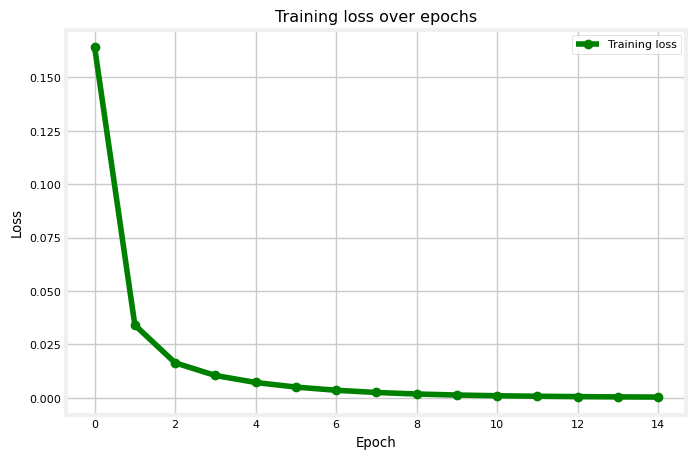

In [40]:
# Plot loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], marker='o', label='Training loss', c='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss over epochs')
plt.legend()
plt.savefig(f"{NN_MODEL_SAVE_FIG}/plot_training_loss_over_epochs.png")
plt.grid(True)
plt.show();

Show updated weights and biases after training.

In [28]:
W1, b1 = model.get_layer('layer1').get_weights()
W2, b2 = model.get_layer('layer2').get_weights()

print("(+) W1:\n", W1, "\n(+) b1:", b1, "\n")
print("(+) W2:\n", W2, "\n(+) b1:", b2)

(+) W1:
 [[-11.11  14.46   0.21]
 [ -0.26  12.06  10.66]] 
(+) b1: [-12.05   1.97  12.81] 

(+) W2:
 [[-57.52]
 [-49.35]
 [ 47.39]] 
(+) b1: [-14.58]


## 3.3 Visualize decision boundary

From updated weights and biases, we can plot the decision boundary.

In [29]:
# def get_2_points_of_straight_line(w1, w2, b):
#     """ w1*x + w2*y + b = 0 
#         (1) : (0, -b/w2)
#         (2) : (-b/w1, 0)
#     """
#     # return (0.0, -b/w2), (-b/w1, 0.0)
#     return  np.array([
#                 [0.0, -b/w2], 
#                 [-b/w1, 0.0]
#             ])

# # w1_1_point1, w1_1_point2 = get_2_points_of_straight_line(W1[0, 0], W1[1, 0], b1[0])
# w1_1_two_points = get_2_points_of_straight_line(W1[0, 0], W1[1, 0], b1[0])
# print(f"{w1_1_two_points}")
# print(type(w1_1_two_points))

# # w1_1_two_points[:, 0]


In [30]:
# # Plot 3 straight
# plt.scatter(x=X[Y.flatten()==0, 0], y=X[Y.flatten()==0, 1], marker='o', label='y=0 (Bad roast)', facecolors='none', edgecolors='blue', s=111)
# plt.scatter(x=X[Y.flatten()==1, 0], y=X[Y.flatten()==1, 1], marker='X', label='y=1 (Good roast)', c='red', s=69)
# # plt.plot(w1_1_two_points[:, 0], w1_1_two_points[:, 1])
# plt.axline(xy1=w1_1_two_points[:, 0], xy2=w1_1_two_points[:, 1], color='purple', linestyle='-', label='Two points')

# plt.legend(loc='upper right')
# plt.xlabel("Temperature\n(Celsius)")
# plt.ylabel("Duration\n(minutes)")
# plt.title("Coffee Roasting")

# plt.show();

In [31]:
# # Vẽ Decision Boundary bằng contour plot
# # Tạo grid các điểm trong không gian feature

# # Xác định range cho Temperature và Duration
# temp_min, temp_max = X[:, 0].min() - 10, X[:, 0].max() + 10
# dur_min, dur_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# # Tạo meshgrid
# xx, yy = np.meshgrid(
#     np.linspace(temp_min, temp_max, 200),
#     np.linspace(dur_min, dur_max, 200)
# )

# # Tạo grid points để predict
# grid_points = np.c_[xx.ravel(), yy.ravel()]  # shape: (40000, 2)

# # Normalize grid points (dùng cùng norm_layer đã fit với X)
# grid_points_norm = norm_layer(grid_points)

# # Predict trên grid
# Z = model.predict(grid_points_norm, verbose=0)
# Z = Z.reshape(xx.shape)

# # Vẽ
# plt.figure(figsize=(10, 7))

# # Vẽ contour fill cho probability
# contour = plt.contourf(xx, yy, Z, levels=50, cmap='RdYlBu_r', alpha=0.6)
# plt.colorbar(contour, label='Probability (Good Roast)')

# # Vẽ decision boundary (threshold = 0.5)
# plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')

# # Vẽ data points
# plt.scatter(x=X[Y.flatten()==0, 0], y=X[Y.flatten()==0, 1], 
#             marker='o', label='Bad Roast', facecolors='none', edgecolors='blue', s=80)
# plt.scatter(x=X[Y.flatten()==1, 0], y=X[Y.flatten()==1, 1], 
#             marker='X', label='Good Roast', c='red', s=60)

# plt.xlabel("Temperature (Celsius)")
# plt.ylabel("Duration (minutes)")
# plt.title("Coffee Roasting - Decision Boundary")
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

Layer 1 weights (W1):
 [[-11.11  14.46   0.21]
 [ -0.26  12.06  10.66]]
Layer 1 biases (b1): [-12.05   1.97  12.81]

Layer 2 weights (W2):
 [[-57.52]
 [-49.35]
 [ 47.39]]
Layer 2 biases (b2): [-14.58]

Normalization - Mean: [218.67  13.43], Std: [39.96  1.13]


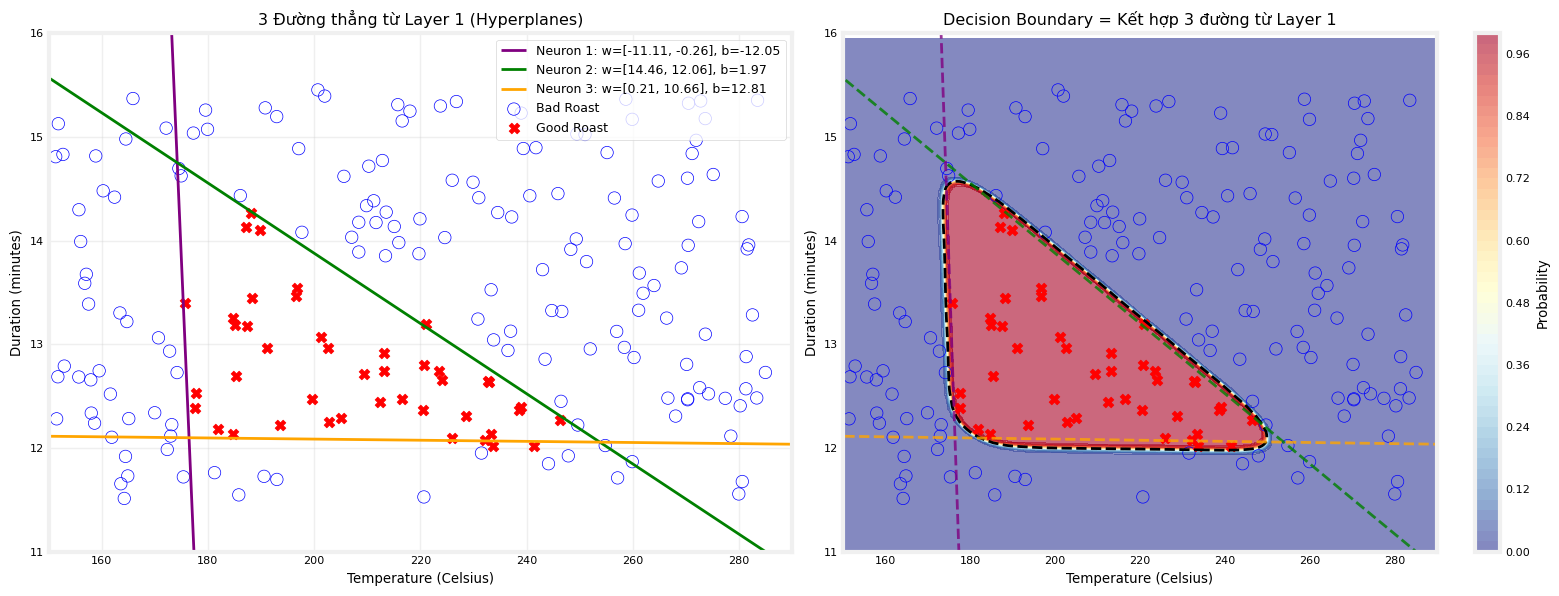


GIẢI THÍCH:
• Mỗi neuron trong Layer 1 tạo ra 1 đường thẳng (hyperplane)
• Sigmoid biến mỗi đường thành 1 'bước nhảy' từ 0 → 1
• Layer 2 kết hợp 3 outputs để tạo vùng 'Good Roast' (hình thang/tam giác)
• Decision boundary cuối cùng là nơi probability = 0.5


In [32]:
# Vẽ 3 đường thẳng từ Layer 1 để hiểu cách chúng tạo nên Decision Boundary
# Mỗi neuron trong layer 1 tạo ra 1 đường thẳng: w1*x1 + w2*x2 + b = 0
# Sau khi qua sigmoid, mỗi đường thẳng chia không gian thành 2 vùng (0 hoặc 1)

# Lấy weights và biases đã train
W1, b1 = model.get_layer('layer1').get_weights()
W2, b2 = model.get_layer('layer2').get_weights()

print("Layer 1 weights (W1):\n", W1)
print("Layer 1 biases (b1):", b1)
print("\nLayer 2 weights (W2):\n", W2)
print("Layer 2 biases (b2):", b2)

# Tính mean và std từ norm_layer để convert ngược về original scale
mean = norm_layer.mean.numpy().flatten()
std = np.sqrt(norm_layer.variance.numpy()).flatten()
print(f"\nNormalization - Mean: {mean}, Std: {std}")

# Hàm vẽ đường thẳng từ weights (trong không gian normalized)
# w1*x1_norm + w2*x2_norm + b = 0
# Chuyển về original scale:
# w1*(x1 - mean1)/std1 + w2*(x2 - mean2)/std2 + b = 0

def get_line_original_scale(w1, w2, b, mean, std, x_range):
    """
    Chuyển đổi đường thẳng từ normalized space về original space
    w1*((x1-mean1)/std1) + w2*((x2-mean2)/std2) + b = 0
    => x2 = -(w1/w2)*(std2/std1)*x1 - (b*std2/w2) + mean2 + (w1*mean1*std2)/(w2*std1)
    """
    # Coefficients trong original space
    slope = -(w1/w2) * (std[1]/std[0])
    intercept = -(b * std[1]/w2) + mean[1] + (w1 * mean[0] * std[1])/(w2 * std[0])
    
    x_vals = np.array(x_range)
    y_vals = slope * x_vals + intercept
    return x_vals, y_vals

# Vẽ
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === Plot 1: 3 đường thẳng từ Layer 1 ===
ax1 = axes[0]
colors = ['purple', 'green', 'orange']
labels = ['Neuron 1', 'Neuron 2', 'Neuron 3']

x_range = [140, 290]

for i in range(3):
    w1, w2 = W1[0, i], W1[1, i]  # weights cho neuron i
    b = b1[i]
    
    x_vals, y_vals = get_line_original_scale(w1, w2, b, mean, std, x_range)
    ax1.plot(x_vals, y_vals, color=colors[i], linewidth=2, 
             label=f'{labels[i]}: w=[{w1:.2f}, {w2:.2f}], b={b:.2f}')

# Vẽ data points
ax1.scatter(x=X[Y.flatten()==0, 0], y=X[Y.flatten()==0, 1], 
            marker='o', facecolors='none', edgecolors='blue', s=80, label='Bad Roast')
ax1.scatter(x=X[Y.flatten()==1, 0], y=X[Y.flatten()==1, 1], 
            marker='X', c='red', s=60, label='Good Roast')

ax1.set_xlim(150, 290)
ax1.set_ylim(11, 16)
ax1.set_xlabel("Temperature (Celsius)")
ax1.set_ylabel("Duration (minutes)")
ax1.set_title("3 Đường thẳng từ Layer 1 (Hyperplanes)")
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# === Plot 2: Decision Boundary cuối cùng ===
ax2 = axes[1]

# Vẽ contour
temp_min, temp_max = X[:, 0].min() - 10, X[:, 0].max() + 10
dur_min, dur_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(temp_min, temp_max, 200),
                      np.linspace(dur_min, dur_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_norm = norm_layer(grid_points)
Z = model.predict(grid_points_norm, verbose=0).reshape(xx.shape)

contour = ax2.contourf(xx, yy, Z, levels=50, cmap='RdYlBu_r', alpha=0.6)
plt.colorbar(contour, ax=ax2, label='Probability')
ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')

# Vẽ 3 đường thẳng layer 1 lên decision boundary
for i in range(3):
    w1, w2 = W1[0, i], W1[1, i]
    b = b1[i]
    x_vals, y_vals = get_line_original_scale(w1, w2, b, mean, std, x_range)
    ax2.plot(x_vals, y_vals, color=colors[i], linewidth=2, linestyle='--', alpha=0.8)

ax2.scatter(x=X[Y.flatten()==0, 0], y=X[Y.flatten()==0, 1], 
            marker='o', facecolors='none', edgecolors='blue', s=80)
ax2.scatter(x=X[Y.flatten()==1, 0], y=X[Y.flatten()==1, 1], 
            marker='X', c='red', s=60)

ax2.set_xlim(150, 290)
ax2.set_ylim(11, 16)
ax2.set_xlabel("Temperature (Celsius)")
ax2.set_ylabel("Duration (minutes)")
ax2.set_title("Decision Boundary = Kết hợp 3 đường từ Layer 1")

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("GIẢI THÍCH:")
print("="*70)
print("• Mỗi neuron trong Layer 1 tạo ra 1 đường thẳng (hyperplane)")
print("• Sigmoid biến mỗi đường thành 1 'bước nhảy' từ 0 → 1")  
print("• Layer 2 kết hợp 3 outputs để tạo vùng 'Good Roast' (hình thang/tam giác)")
print("• Decision boundary cuối cùng là nơi probability = 0.5")

# 4. Prediction

## 4.1 Load the model

In [33]:
loaded_model = tf.keras.models.load_model(model_file_path)
print("[OK] Model loaded successfully!")
print(loaded_model.summary())

[OK] Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (168.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28 (116.00 B)

None


The threshold for classification is 0.5

In [34]:
THRESHOLD = 0.5

In [35]:
X_test = np.array([
    [200, 12.9],    # positive example
    [200, 17]       # negative example
])
X_test_norm = norm_layer(X_test)


In [36]:
# Predict:
# predictions = model.predict(X_test_norm, verbose=1)

# Predict with loaded model:
predictions = loaded_model.predict(X_test_norm, verbose=1)
print("Prediction = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction = 
 [[1.00e+00]
 [1.46e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction = 
 [[1.00e+00]
 [1.46e-08]]


Apply the **threshold**, convert probability to a decision 1|0

In [37]:
y_hat = np.zeros_like(predictions)

for i in range(len(predictions)):
    if predictions[i, 0] >= 0.5:
        y_hat[i] = 1
    else:
        y_hat[i] = 0
    
print(f"Decision:\n",y_hat)

Decision:
 [[1.]
 [0.]]


Or more succinctly:

In [38]:
y_hat = (predictions >= 0.5).astype(int)
print(f"Decisions =\n", y_hat)

Decisions =
 [[1]
 [0]]


# Congratulations!